In [1]:
# This notebook is run via kaggle T4 GPUs

# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import re
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, accuracy_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import pickle

# Enable GPUs

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    print(gpus)
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)
else:
    print("No GPU found, using CPU.")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


# Loading Dataset

In [ ]:
df = pd.read_csv("../dataset/processed/final_datasets.csv")
df.head()

,title,text,unreliable,author
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,1,Unknown
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,1,Unknown
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",1,Unknown
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",1,Unknown
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,1,Unknown


# Pre-processsing

In [4]:
df.isna().sum()

title          558
text            40
unreliable       0
author        1957
dtype: int64

In [5]:
df.fillna({"text":"", "title":"", "author":"Unknown"}, inplace=True)

In [6]:
df.isna().sum()

title         0
text          0
unreliable    0
author        0
dtype: int64

In [7]:
# Combine title, author, and text
df["content"] = df["title"] + " " + df["author"] + " " + df["text"]

In [8]:
def clean_text(text):
    text = re.sub(r"\W", " ", text)  # Remove special chars
    text = re.sub(r"\d", " ", text)  # Remove numbers
    text = re.sub(r"\s+", " ", text).strip()  # Remove extra spaces
    return text.lower()

df["content"] = df["content"].apply(clean_text)
df.head()

,title,text,unreliable,author,content
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,1,Unknown,donald trump sends out embarrassing new year s...
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,1,Unknown,drunk bragging trump staffer started russian c...
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",1,Unknown,sheriff david clarke becomes an internet joke ...
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",1,Unknown,trump is so obsessed he even has obama s name ...
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,1,Unknown,pope francis just called out donald trump duri...


In [9]:
# Tokenization
vocab_size = 160_000
max_length = 500
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(df["content"])

In [10]:
# Convert text to sequences
sequences = tokenizer.texts_to_sequences(df["content"])
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding="post", truncating="post")

In [11]:
y = df["unreliable"]

In [12]:
# Train-validation-test split
X_train, X_temp, y_train, y_temp = train_test_split(padded_sequences, y, test_size=0.1, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Model Building

In [13]:
# Build LSTM Model
embedding_dim = 300
hidden_dim = 128

model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim),
    LSTM(hidden_dim, return_sequences=True),
    Dropout(0.3),
    LSTM(hidden_dim),
    Dropout(0.3),
    Dense(64, activation="relu"),
    Dense(1, activation="sigmoid")
])

In [14]:
model.compile(optimizer=Adam(learning_rate=0.0025), loss="binary_crossentropy", metrics=["accuracy"])
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

In [15]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=40, epochs=50,
                    callbacks=[early_stopping])

Epoch 1/50
1479/1479 ━━━━━━━━━━━━━━━━━━━━ 107s 66ms/step - accuracy: 0.5826 - loss: 0.6623 - val_accuracy: 0.8618 - val_loss: 0.5118
Epoch 2/50
1479/1479 ━━━━━━━━━━━━━━━━━━━━ 101s 68ms/step - accuracy: 0.9368 - loss: 0.1785 - val_accuracy: 0.9799 - val_loss: 0.0597
Epoch 3/50
1479/1479 ━━━━━━━━━━━━━━━━━━━━ 101s 68ms/step - accuracy: 0.9908 - loss: 0.0320 - val_accuracy: 0.9826 - val_loss: 0.0532
Epoch 4/50
1479/1479 ━━━━━━━━━━━━━━━━━━━━ 101s 68ms/step - accuracy: 0.9957 - loss: 0.0137 - val_accuracy: 0.9823 - val_loss: 0.0628
Epoch 5/50
1479/1479 ━━━━━━━━━━━━━━━━━━━━ 101s 68ms/step - accuracy: 0.9971 - loss: 0.0089 - val_accuracy: 0.9799 - val_loss: 0.0764
Epoch 6/50
1479/1479 ━━━━━━━━━━━━━━━━━━━━ 101s 68ms/step - accuracy: 0.9980 - loss: 0.0068 - val_accuracy: 0.9878 - val_loss: 0.0477
Epoch 7/50
1479/1479 ━━━━━━━━━━━━━━━━━━━━ 101s 68ms/step - accuracy: 0.9983 - loss: 0.0067 - val_accuracy: 0.9881 - val_loss: 0.0595
Epoch 8/50
1479/1479 ━━━━━━━━━━━━━━━━━━━━ 101s 68ms/step - accuracy: 

Text(0.5, 1.0, 'Model Accuracy')

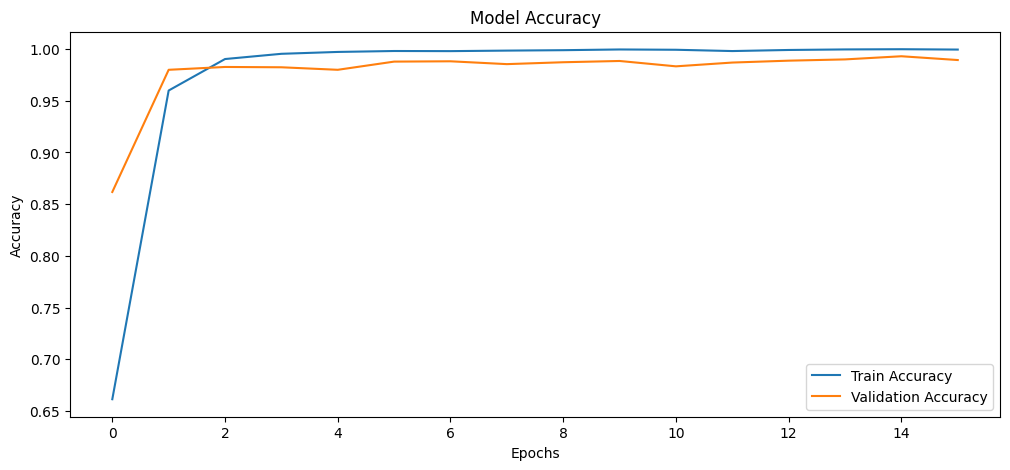

In [16]:
plt.figure(figsize=(12,5))
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Model Accuracy")

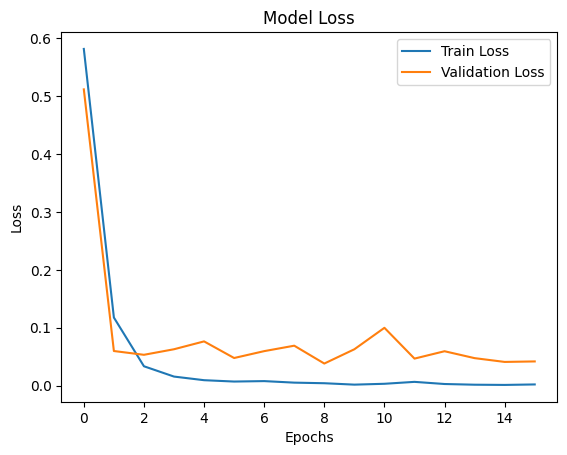

In [17]:
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Model Loss")
plt.show()

# Model Evaluation

In [18]:
# Evaluate model on test set
y_pred = (model.predict(X_test) > 0.5).astype("int32")
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
test_accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
print(f"Accuracy: {test_accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1-Score: {f1_score}")

103/103 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step
Accuracy: 0.9914764079147641
Precision: 0.9946107784431137
Recall: 0.9886904761904762
F1-Score: 0.9916417910447761


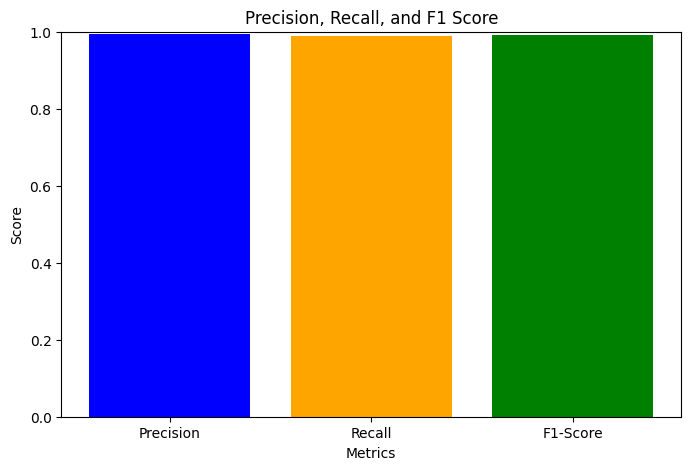

In [19]:
# Plot Precision, Recall, and F1 Score
plt.figure(figsize=(8,5))
plt.bar(["Precision", "Recall", "F1-Score"], [precision, recall, f1_score], color=["blue", "orange", "green"])
plt.xlabel("Metrics")
plt.ylabel("Score")
plt.title("Precision, Recall, and F1 Score")
plt.ylim(0,1)
plt.show()

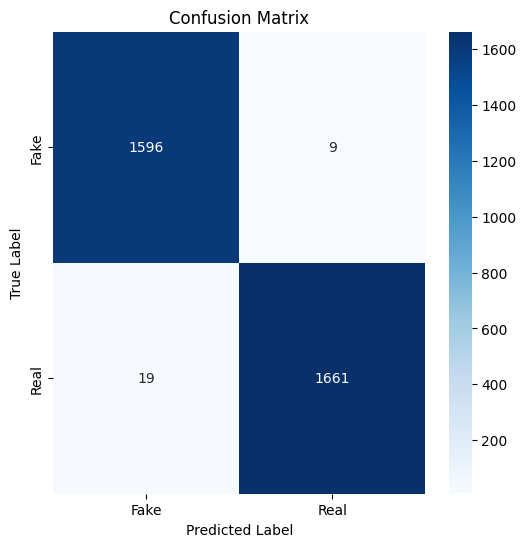

In [20]:
# Plot Confusion Matrix
plt.figure(figsize=(6,6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Fake", "Real"], yticklabels=["Fake", "Real"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Saving the Model

In [ ]:
with open("../models/tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

In [ ]:
model.save("../models/lstm_model.h5")